In [1]:
cd W:\User\Papers\E(t)-paper\Software\141216

W:\User\Papers\E(t)-paper\Software\141216


In [2]:
%matplotlib inline

In [3]:
import mfm
from mfm.fluorescence.fps.dynamic import Sticking, Dye, ProteinQuenching, DiffusionSimulationParameter, \
    DiffusionSimulation
from mfm.fluorescence.simulation.dye_diffusion import DyeDecay, DecaySimulationParameter, FRETDecay
from mfm.fitting.models.tcspc.tcspc import FretParameter
from mfm.fitting.optimization import solve_nnls, maxent
import numpy as np
import itertools
import pylab as p

mfm.verbose = False

# Custom functions

First I define some custom function for batch processing of decays.

In [4]:
def simulate_decays(dyes, decay_parameter, simulation_parameter, quenching_parameter, save_decays=True,
                    directory="./"):
    dye_decays = dict()

    for dye_key in dyes:
        print "Simulating decay: %s" % dye_key
        dye = dyes[dye_key]
        diffusion_simulation = DiffusionSimulation(dye,
                                                   quenching_parameter,
                                                   simulation_parameter)
        diffusion_simulation.update()
        diffusion_simulation.save('%sD_diffusion.xyz' % dye_key, mode='xyz', skip=5)
        av = diffusion_simulation.av
        av.save('%sD' % dye_key)

        fd0_sim_curve = DyeDecay(decay_parameter, diffusion_simulation)
        fd0_sim_curve.update()
        decay = fd0_sim_curve.get_histogram()
        print "QY: %s" % fd0_sim_curve.quantum_yield
        filename = "Donor-%s.txt" % dye_key
        decay = np.vstack(decay)
        if save_decays:
            np.savetxt(directory+filename, decay.T)
        dye_decays[dye_key] = decay
    return dye_decays

In [5]:
def simulate_fret_decays(donors, acceptors, decay_parameter, simulation_parameter, donor_quenching, acceptor_quenching,
                         fret_parameter, save=True, directory="./"):
    donor_keys = donors.keys()
    acceptor_keys = acceptors.keys()
    fret_decays = dict(
        (donor_key, dict()) for donor_key in donor_keys
    )
    
    distances = dict(
        (donor_key, dict()) for donor_key in donor_keys
    )
    
    dye_combinations = itertools.product(donor_keys, acceptor_keys)
    for donor_key, acceptor_key in dye_combinations:
        print "Simulating: %sD-%sA" % (donor_key, acceptor_key)
        donor = donors[donor_key]
        acceptor = acceptors[acceptor_key]

        donor_diffusion_simulation = DiffusionSimulation(donor,
                                                         donor_quenching,
                                                         simulation_parameter)
        donor_diffusion_simulation.update()

        acceptor_diffusion_simulation = DiffusionSimulation(acceptor,
                                                            acceptor_quenching,
                                                            simulation_parameter)
        acceptor_diffusion_simulation.update()

        fret_sim = FRETDecay(donor_diffusion_simulation, acceptor_diffusion_simulation,
                             fret_parameter, decay_parameter)
        fret_sim.update()
        decay = fret_sim.get_histogram()
        decay = np.vstack(decay)
        if save:
            np.savetxt(directory+"FRET-%sD-%sA-dRDA.txt" % (donor_key, acceptor_key), fret_sim.dRDA.T)
            np.savetxt(directory+"FRET-%sD-%sA.txt" % (donor_key, acceptor_key), decay.T)
        fret_decays[donor_key][acceptor_key] = decay
        distances[donor_key][acceptor_key] = np.histogram(fret_sim.dRDA, bins=np.linspace(0, 150, 150), density=True)
    return fret_decays, distances

# Simulation parameters

## Structure

There are two PDBs of hGBP1. Both PDBs are coarse grained models of hGBP1. In the coarse model the sidechains are stripped. Instead of the stripped sidechain are pseudo atom was placed at the center of mass of the side-chain. The program identifies the type of the sidechain by the name of the amino-acid. In one PDB the names of the natural amino-acids were used. In the second PDB the names of the natural quenchers (TYR, TRP, HIS, PRO, MET) were replaced by ALA.

Given the PDB-files now a new structure object is generated and the simulation parameters are set.

In [6]:
#pdb_file = '../sample_data/model/hgbp1/hGBP1.pdb'                # This PDB quenched the dye
pdb_file = 'W:/User/Papers/E(t)-paper/Figures/old/Diffusion_simulation/Diffusion_simulation/PDBs/All_Ala_hGBP1/hGBP1_coarse_all_ala.pdb'  # This PDB does not quench the dye
structure = mfm.Structure(pdb_file)

## General Parameters

In [7]:
save_directory = "./tmp/"

## FRET-parameter

In [8]:
tau0 = 4.1
forster_radius = 52.0
kappa2 = 0.667

fret_parameter = FretParameter(tau0=tau0,
                               forster_radius=forster_radius,
                               kappa2=kappa2)

## Dye-definitions

In [9]:
diffusion_coefficient_donor = 30.0     # A2/ns - Stas-paper 7.0 A2/ns
diffusion_coefficient_acceptor = diffusion_coefficient_donor * 0.5  # A2/ns - Stas-paper 1.5 A2/ns
slow_factor = 0.1                     # Diffusion multiplier in boundary - best 0.1
slow_radius = 8.5                     # Defines surface area - best 8.5
directory = "./tmp/"                  # This directory is used for saving

## Donor

In [10]:
#donor_labeling_positions = [18, 254, 577, 344, 481, 496, 525, 540, 577]
donor_labeling_positions = [379]
donor_chains = ['A']*len(donor_labeling_positions)

donor_quenching = ProteinQuenching(structure,
                                   all_atoms_quench=False,
                                   quench_scale=1.0,
)

donor_sticking = Sticking(structure, donor_quenching,
                          sticky_mode='surface',
                          slow_radius=slow_radius,
                          slow_fact=slow_factor)  # Stas-paper Dye-MD (roughly 10%)

donor_dyes = dict(
    [
        (pos,
         Dye(donor_sticking,
             attachment_residue=pos,
             attachment_chain=chain,
             attachment_atom='CB',
             critical_distance=3.0 + 5.5,  # 3.0 Ang von AV + 6.0 Ang only C-beta quench (so far best 5.0 + 3.0)
             diffusion_coefficient=diffusion_coefficient_donor,  # Stas-paper (Dye-MD 30 A2/ns)
             av_radius=3.0,
             av_length=22.0,  # 20 + 5 = 3.5 + 21.5
             tau0=4.2)
        )
        for pos, chain in zip(donor_labeling_positions, donor_chains)
    ]
)

## Acceptor

In [11]:
#acceptor_labeling_positions = [18, 254, 577 , 344, 481, 496, 525, 540, 577]
acceptor_labeling_positions = [467]
acceptor_chains = ['A']*len(donor_labeling_positions)
acceptor_quenching = ProteinQuenching(structure,
                                      all_atoms_quench=False,
                                      quench_scale=0.8)

acceptor_sticking = Sticking(structure, acceptor_quenching,
                             sticky_mode='surface',
                             slow_radius=slow_radius,
                             slow_fact=slow_factor)  # Stas-paper Dye-MD (roughly 10%)
acceptor_quenching = ProteinQuenching(structure,
                                      all_atoms_quench=False,
                                      quench_scale=0.8)
acceptor_dyes = dict(
    [
        (pos,
         Dye(donor_sticking,
             attachment_residue=pos,
             attachment_chain=chain,
             attachment_atom='CB',
             critical_distance=0.0,      # The acceptor dye does not have to be quenched setting this to zero speeds up calulation
             diffusion_coefficient=diffusion_coefficient_acceptor,
             av_radius=3.5,
             tau0=1.0)
        )
        for pos, chain in zip(acceptor_labeling_positions, acceptor_chains)
    ]
)

# Simulation

## Donor-decay

Now the simulation parameters are set.

In [12]:
simulation_parameter = DiffusionSimulationParameter(t_max=512000,
                                                    t_step=0.064)
decay_parameter = DecaySimulationParameter(decay_mode='photon',
                                           n_photons=50.0e6,
                                           tac_range=(0, 20),
                                           dt_tac=0.016)
#decay_parameter = DecaySimulationParameter(decay_mode='curve',
#                                           n_curves=25000,
#                                           n_tac = 4096,
#                                           dt_tac=0.016)

In [13]:
donor_decays = simulate_decays(donor_dyes, decay_parameter, simulation_parameter, donor_quenching, directory=save_directory)

Simulating decay: 379
QY: 0.998514509716


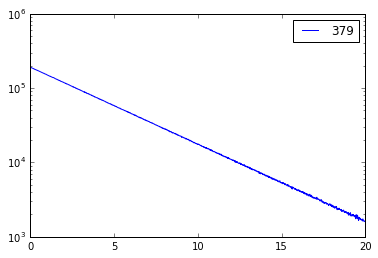

(1249L,)


In [14]:
for k in donor_decays:
    p.semilogy(donor_decays[k][0], donor_decays[k][1], label='%s' % k)
p.legend()
p.show()
print donor_decays[379][0].shape

## FRET-decay

In [15]:
fret_decays, distance_distributions = simulate_fret_decays(donor_dyes, acceptor_dyes, decay_parameter, simulation_parameter, 
                                                           donor_quenching, acceptor_quenching, fret_parameter,
                                                           directory=save_directory)

Simulating: 379D-467A


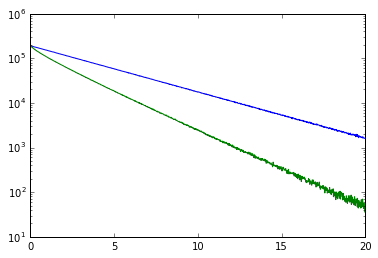

In [16]:
for donor_key in donor_decays:
    t, fd0 = donor_decays[donor_key]
    p.semilogy(t, fd0)
    fret = fret_decays[donor_key]
    for acceptor_key in fret:
        t, fda = fret_decays[donor_key][acceptor_key]
        p.semilogy(t, fda)
    p.show()

## E(t)-decay

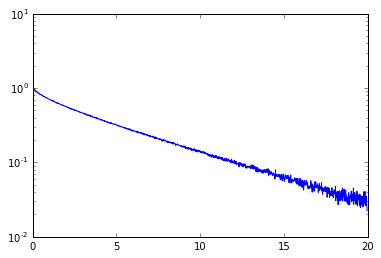

In [17]:
et_decays = dict(
    (donor_key, dict(
        (acceptor_key, (fret_decays[donor_key][acceptor_key][0], fret_decays[donor_key][acceptor_key][1]/donor_decays[donor_key][1]))
        for acceptor_key in fret_decays[donor_key].keys()
    )
    ) for donor_key in donor_decays.keys()
)

for donor_key in donor_decays:
    t, fd0 = donor_decays[donor_key]
    fret = fret_decays[donor_key]
    for acceptor_key in fret:
        t, et = et_decays[donor_key][acceptor_key]
        p.semilogy(t, et)
    p.show()

## Deconvolution of E(t)-decay

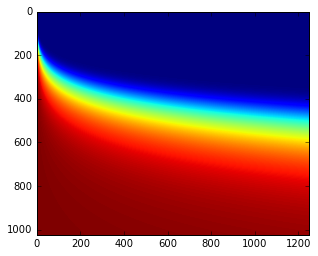

In [18]:
t_matrix, r_DA = mfm.fluorescence.calc_transfer_matrix(t, rDA_min=10.0, rDA_max=128.0, n_steps=1024, space='lin', 
                                                       kappa2=kappa2, tau0=tau0, R0=forster_radius)
p.imshow(t_matrix)

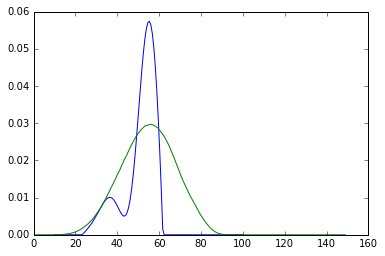

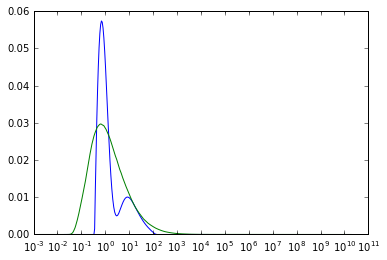

Recovered mean: 50.8969465522
True mean     : 54.8252447567


In [19]:
regularization_factor = 1.0

for donor_key in et_decays:
    et_a = fret_decays[donor_key]
    for acceptor_key in et_a:
        t, et = et_decays[donor_key][acceptor_key]
        
        t_matrix, r_DA = mfm.fluorescence.calc_transfer_matrix(t, rDA_min=10.0, rDA_max=100.0, n_steps=128, space='lin', 
                                                               kappa2=kappa2, tau0=tau0, R0=forster_radius)
        t_matrix[t_matrix < 0.0] = 0.0
        
        #p_rDA = maxent(t_matrix.T, et, regularization_factor)
        p_rDA = solve_nnls(t_matrix, et, regularization_factor)
        #p_rDA = np.linalg.lstsq(t_matrix.T, et, regularization_factor)[0]
        hist, edges = distance_distributions[donor_key][acceptor_key]
        
        p.plot(r_DA, p_rDA)
        p.plot(edges[:-1], hist)
        p.show()

        p.semilogx(forster_radius**6 / r_DA**6, p_rDA)
        p.semilogx(forster_radius**6 / edges[:-1]**6, hist)
        p.show()

        print "Recovered mean: %s" % (np.dot(r_DA, p_rDA/sum(p_rDA)))
        print "True mean     : %s" % (np.dot(edges[:-1], hist/sum(hist)))

In [20]:
np.savetxt("./tmp/r_axis.txt", r_DA)
np.savetxt("./tmp/sticking_p_30.0_15.0_rDA.txt", p_rDA)